## Long Short Equity Across TOP500 Stocks

* $t_i$: Information obtained at close used to formulate positions across all 500 stocks
* $t_{i+1}$: Position changes and `pnl` calculated using `np.multiply(pos, returns)` where returns are $\frac{t_{i+1}}{t_i}-1$

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sb
from tabulate import tabulate

In [2]:
# Get S&P500 information and store tickers in a list
sp500 = pd.read_csv('constituents.csv')
tickers = sp500["Symbol"]
tickers = tickers.tolist()

# Get returns for S&P500
start = '2010-01-01'
end = '2021-01-01'
adj_close = yf.download(tickers, start=start, end=end)["Adj Close"]

[*********************100%***********************]  505 of 505 completed

22 Failed downloads:
- DISCK: No data found, symbol may be delisted
- PBCT: No data found, symbol may be delisted
- ANTM: No data found, symbol may be delisted
- KSU: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- CERN: No data found, symbol may be delisted
- CTXS: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- FRC: Data doesn't exist for startDate = 1262275200, endDate = 1609430400
- WLTW: No data found, symbol may be delisted
- FBHS: No data found, symbol may be delisted
- DISCA: No data found, symbol may be delisted
- XLNX: No data found, symbol may be delisted
- DRE: No data found, symbol may be delisted
- TWTR: No data found, symbol may be delisted
- NLOK: No data found, symbol may be delisted
- FB: No data found, symbol may be delisted
- INFO: No data found, symbol may be delisted
- VIAC: No data found, symbol

In [3]:
adj_close

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,20.119396,4.562870,36.794746,6.405577,NaN,21.468946,8.730000,19.169519,32.264996,36.779999,...,13.485926,NaN,41.098988,31.977121,NaN,19.459595,52.190178,28.350000,10.627426,NaN
2010-01-04,20.268343,4.496877,36.703854,6.505281,NaN,21.930117,8.740000,19.336403,32.708145,37.090000,...,13.396952,NaN,41.677605,32.122616,NaN,19.526367,52.993641,28.670000,11.041594,NaN
2010-01-05,20.048172,5.005958,36.485703,6.516528,NaN,21.773653,8.530000,19.180176,32.910305,37.700001,...,13.238073,NaN,41.840332,31.740747,NaN,19.459595,54.671215,28.620001,11.430906,NaN
2010-01-06,19.976940,4.798554,36.803844,6.412871,NaN,21.567778,8.400000,19.286694,33.260162,37.619999,...,13.263497,NaN,42.201977,31.949854,NaN,19.320478,54.653542,28.400000,12.424898,NaN
2010-01-07,19.951042,4.939966,36.794746,6.401019,NaN,21.221891,8.400000,19.446466,33.229073,36.889999,...,13.206300,NaN,42.069363,32.368092,NaN,19.314915,55.907318,27.690001,13.816484,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,115.538185,15.660000,150.820129,130.205780,93.089394,94.035629,303.410004,103.947304,248.739563,499.859985,...,60.670856,NaN,37.406952,50.531242,97.725655,103.296951,142.506317,376.890015,40.809158,157.963867
2020-12-28,116.050339,16.059999,149.055481,134.862671,93.260674,93.870766,312.910004,103.410057,251.040375,498.950012,...,61.318596,NaN,37.532848,51.009056,97.842644,105.448563,142.162567,382.589996,40.827988,159.605225
2020-12-29,115.459381,15.860000,147.074951,133.067017,94.387558,94.181091,320.929993,103.928123,249.184280,502.109985,...,61.412453,NaN,37.110222,49.975414,97.004288,105.131584,145.561707,378.040009,40.272446,160.322693


In [4]:
adj_close_arr = adj_close.to_numpy()

In [5]:
adj_close_arr.shape

(2770, 505)

### Essential Functions

In [6]:
def shiftArr(arr, n):
    out = np.full_like(arr, np.nan)
    out[:-n] = arr[n:]
    return out

def normalize(arr):
    return arr-np.nanmean(arr, axis=1).reshape(-1, 1)

def scale(arr, booksize=20e6):
    return arr/np.nansum(abs(arr), axis=1, dtype=float).reshape(-1,1) * booksize

In [7]:
import numba
@numba.njit

def group_neutralize(arr, group, min=2):
    for di in range(len(arr)):
        unique_groups = np.unique(group[di])
        unique_groups = unique_groups[~np.isnan(unique_groups)]
        for g in unique_groups:
            if len(arr[di][group[di]==g]) >= min:
                arr[di] -= np.ones(arr[di].shape) * np.nanmean(arr[di][group[di]==g]) * (group[di]==g)
            else:
                arr[di][group[di]==g] = 0
    return arr

In [8]:
def tsdelta(arr, lookback=10):
    out = arr.copy()
    for di in range(lookback):
        out[di] = np.nan
    for di in range(lookback, len(arr)):
        out[di] = arr[di] - arr[di-lookback]
    return out

def tszscore(arr, lookback=10):
    out = arr.copy()
    for di in range(lookback):
        out[di] = np.nan
    for di in range(lookback, len(arr)):
        out[di] = (out[di] - np.nanmean(arr[di-lookback:di], axis=0)) / np.nanstd(arr[di-lookback:di], axis=0)
    return out

def maWindow(returns, window=5):
    out = np.copy(returns)
    for di in range(window):
        out[di] = np.nan
    for idx, row in enumerate(out):
        if idx >= window-1:
            out[idx] = np.mean(returns[idx-window+1:idx+1], axis=0)
        else:
            continue
    return out

In [9]:
def sharpe(pnl):
    s = np.nanmean(pnl) / np.nanstd(pnl) * np.sqrt(252)
    return s

def mdd(portfolio):
    peak = portfolio[0]
    max_draw = 0
    for idx, value in enumerate(portfolio):
        if value >= peak:
            peak = value
            peakidx = idx
        else:
            dd = ((value - peak)/peak) * 100
            if dd < max_draw:
                mddpeak = [peak, peakidx]
                trough = [value, idx]
                max_draw = dd
    return max_draw, mddpeak, trough

def turnover(alpha, booksize=20e6):
    lastDay = 0
    days = 0
    totalTurnover = 0
    for idx, day in enumerate(alpha):
        if idx!=0:
            posChange = day-lastDay
            bought = abs(posChange[posChange > 0].sum())
            sold = abs(posChange[posChange < 0].sum())
            dayTurnover = min(bought, sold)/booksize
            totalTurnover += dayTurnover
            days += 1
        lastDay = day
    return (totalTurnover/days) * 100

def lsReturns(alpha, returns):
    long = alpha.copy()
    long[long < 0] = 0
    longiipnl = np.multiply(long, returns)
    longpnl = np.nansum(longiipnl, axis=1)
    
    short = alpha.copy()
    short[short > 0] = 0
    shortiipnl = np.multiply(short, returns)
    shortpnl = np.nansum(shortiipnl, axis=1)
    
    return longpnl, shortpnl

### Alpha 1: 5d Returns Reversion

In [10]:
returns = (shiftArr(adj_close_arr,1) - adj_close_arr)/adj_close_arr
a = -tsdelta(adj_close_arr, 5)/adj_close_arr
b = normalize(a)
c = scale(b)
alpha = c

/var/folders/3q/cdf3qrtj06d84q4x0l6xslsr0000gn/T/ipykernel_54177/956451732.py:7: RuntimeWarning: Mean of empty slice
  return arr-np.nanmean(arr, axis=1).reshape(-1, 1)


In [11]:
iipnl = np.multiply(alpha, returns)
pnl = np.nansum(iipnl, axis=1)

+----+----------+-----------+------------+----------+------------+--------------+
|    |   sharpe |   returns |   turnover |      mdd |   longOnly |    shortOnly |
|----+----------+-----------+------------+----------+------------+--------------|
|  0 | 0.733226 |    5.5789 |     31.308 | -21.7539 | 2.8184e+07 | -1.59193e+07 |
+----+----------+-----------+------------+----------+------------+--------------+


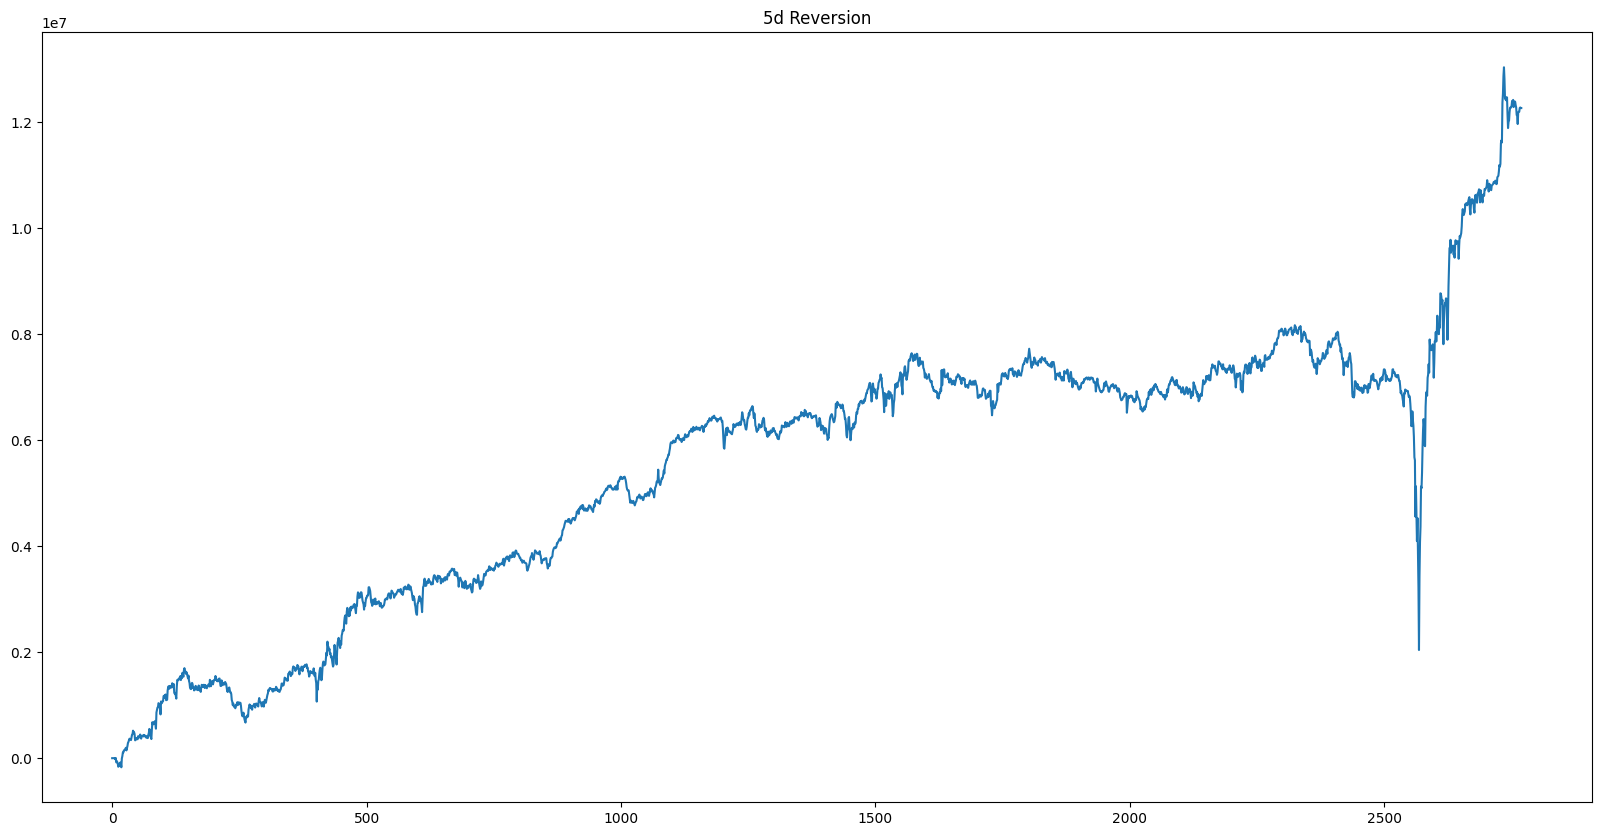

In [12]:
fig, ax = plt.subplots(1, figsize=(20,10), dpi=100)
ax.plot(pnl.cumsum())
ax.set_title('5d Reversion')

s = sharpe(pnl)
total_returns = np.nanmean(pnl)/20e6 * 252 * 100

cum_pnl = pnl.cumsum()
max_dd = mdd(cum_pnl+20e6)
tvr = turnover(alpha)
long, short = lsReturns(alpha, returns)

print(tabulate(pd.DataFrame.from_dict(dict(sharpe=[s], returns=[total_returns], turnover=[tvr], mdd=[max_dd[0]],
                                          longOnly=[long.sum()], shortOnly=[short.sum()])),
              headers='keys', tablefmt='psql'))

plt.show();

### Alpha 2: MA Reversion

In [13]:
returns = (shiftArr(adj_close_arr,1) - adj_close_arr)/adj_close_arr
a = maWindow(adj_close_arr, 20) - adj_close_arr
b = normalize(a)
c = scale(b)
alpha = c

/var/folders/3q/cdf3qrtj06d84q4x0l6xslsr0000gn/T/ipykernel_54177/956451732.py:7: RuntimeWarning: Mean of empty slice
  return arr-np.nanmean(arr, axis=1).reshape(-1, 1)


In [14]:
iipnl = np.multiply(alpha, returns)
pnl = np.nansum(iipnl, axis=1)

+----+----------+-----------+------------+----------+-------------+--------------+
|    |   sharpe |   returns |   turnover |      mdd |    longOnly |    shortOnly |
|----+----------+-----------+------------+----------+-------------+--------------|
|  0 |  1.26125 |   7.23438 |    18.7046 | -7.84181 | 2.92796e+07 | -1.33754e+07 |
+----+----------+-----------+------------+----------+-------------+--------------+


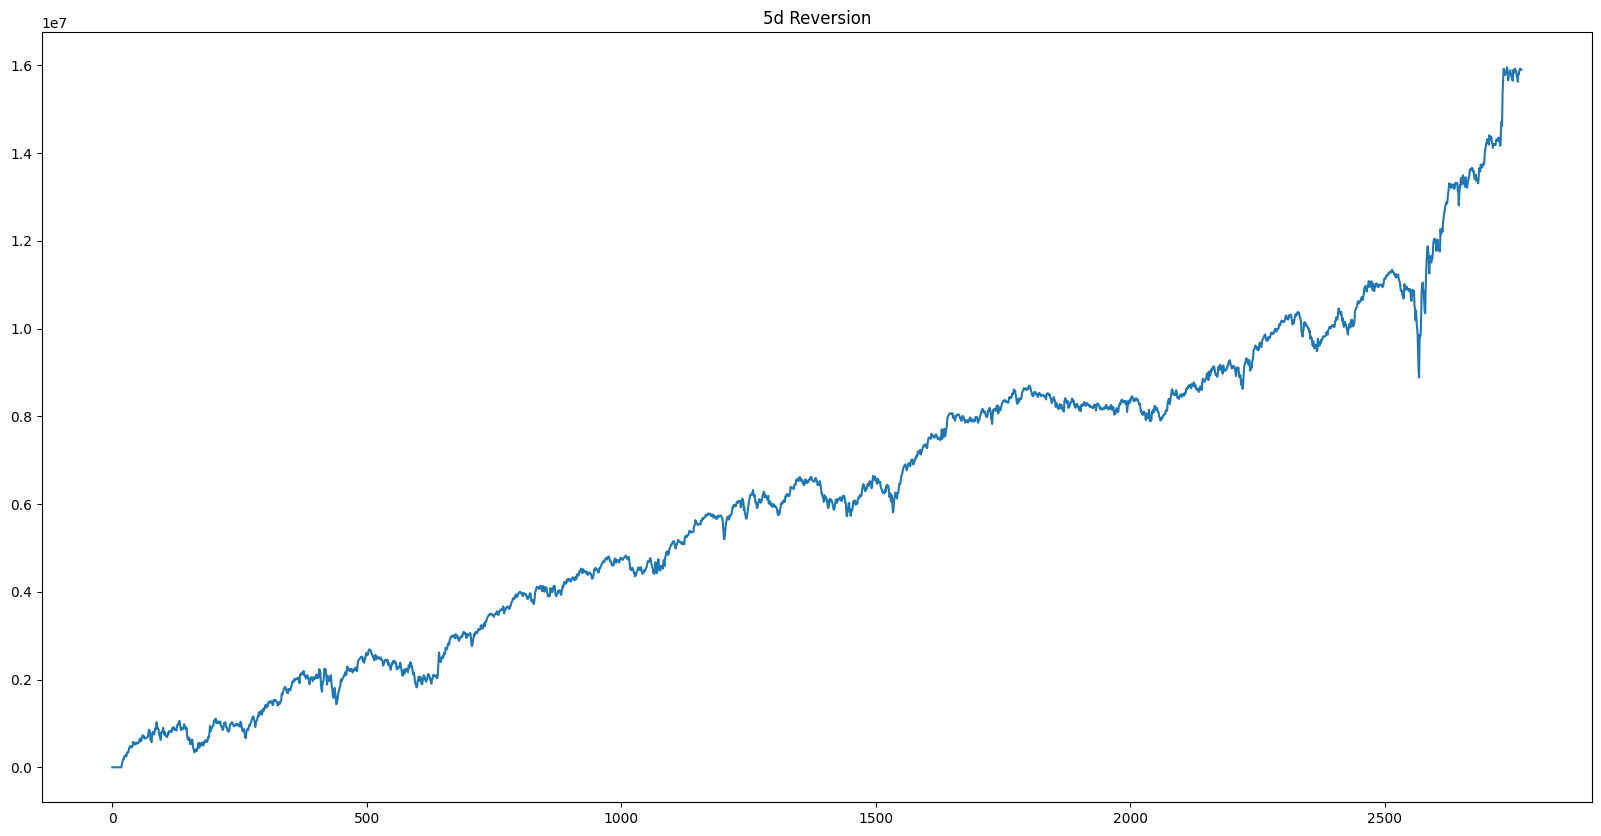

In [15]:
fig, ax = plt.subplots(1, figsize=(20,10), dpi=100)
ax.plot(pnl.cumsum())
ax.set_title('5d Reversion')

s = sharpe(pnl)
total_returns = np.nanmean(pnl)/20e6 * 252 * 100

cum_pnl = pnl.cumsum()
max_dd = mdd(cum_pnl+20e6)
tvr = turnover(alpha)
long, short = lsReturns(alpha, returns)

print(tabulate(pd.DataFrame.from_dict(dict(sharpe=[s], returns=[total_returns], turnover=[tvr], mdd=[max_dd[0]],
                                          longOnly=[long.sum()], shortOnly=[short.sum()])),
              headers='keys', tablefmt='psql'))

plt.show();